In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pdal

## EARLY EDA NOTEBOOK
---------

The purpose of including this notebook was just to show how I was trying to get my hands around the lidar data and using the tools from the PDAL package. A lot of the techniques used in this book became extremely valuable conceptually as I moved forward, but ultimately weren't used in the final pipeline.

Also, some cool visualizations.

In [2]:
data = "Armenia-cropped-croppedagain.las"

json = """
    {
      "pipeline": [
        {
            "type": "readers.las",
            "filename": "%s"
        }
      ]
    }"""


pipeline = pdal.Pipeline(json % data)
count = pipeline.execute()

# get the data from the first array
# [array([(637012.24, 849028.31, 431.66, 143, 1,
# 1, 1, 0, 1,  -9., 132, 7326, 245380.78254963,  68,  77,  88),
# dtype=[('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Intensity', '<u2'),
# ('ReturnNumber', 'u1'), ('NumberOfReturns', 'u1'), ('ScanDirectionFlag', 'u1'),
# ('EdgeOfFlightLine', 'u1'), ('Classification', 'u1'), ('ScanAngleRank', '<f4'),
# ('UserData', 'u1'), ('PointSourceId', '<u2'),
# ('GpsTime', '<f8'), ('Red', '<u2'), ('Green', '<u2'), ('Blue', '<u2')])

arr = pipeline.arrays[0]
print (len(arr)) # 1065 points



118460556


In [3]:
df=pd.DataFrame(arr, columns =["X","Y","Z"])

In [4]:
df.describe()

,X,Y,Z
count,1.184606e+08,1.184606e+08,1.184606e+08
mean,-3.636098e-01,6.425728e-01,2.924669e+00
std,4.689967e+00,5.091768e+00,2.900326e+00
min,-7.500000e+00,-7.900000e+00,-1.500000e+00
25%,-4.400000e+00,-3.440000e+00,2.200000e-01
50%,-7.100000e-01,1.170000e+00,3.240000e+00
75%,3.570000e+00,5.200000e+00,5.490000e+00
max,7.450000e+00,8.500000e+00,1.292000e+01


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176735842 entries, 0 to 176735841
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   X       float64
 1   Y       float64
 2   Z       float64
dtypes: float64(3)
memory usage: 4.0 GB


The chunk is a depth clamper for visualizing the plan. In other words, it isolates a 'slice' of the model to display. I generally do not vis over .1 in any direction due to potential crashes. 

x_neg, x_pos etc. are crop boundaries determined using the below process. 

In [5]:
chunk = ((df.Z > (1)) & (df.Z < 1.1))

In [ ]:
x_neg = -7.5
x_pos = 7.45
y_neg = -7.9
y_pos = 8.5

**THE FOLLOWING HAS BEEN MOVED TO A STREAMED PROCESS W/ PDAL ON THE COMMAND LINE**

**You can find 'cropper-copy1.json' cropping bounds which were determined using the below process. In order to visualize the lidar file, the file needed to be down sampled using KNN. Once the 'fine tuned' crop boundaries were found, this process could be pushed back to the command line pdal and downsampling removed.**

The original plotting activities involved drawing a 'fine' crop line around the area of interest, which was not possible with the commandline transformation/sampling on the raw file due to the inability to visualize it. The code below is the result of trial and error lining up the crop boundaries.

This likely could be coded and generalized in some way, but it is currently beyond me how a task like this would be accomplished. My goal was to isolate only the interior of the main space + cupola. Down to ~42,000,000 rows.

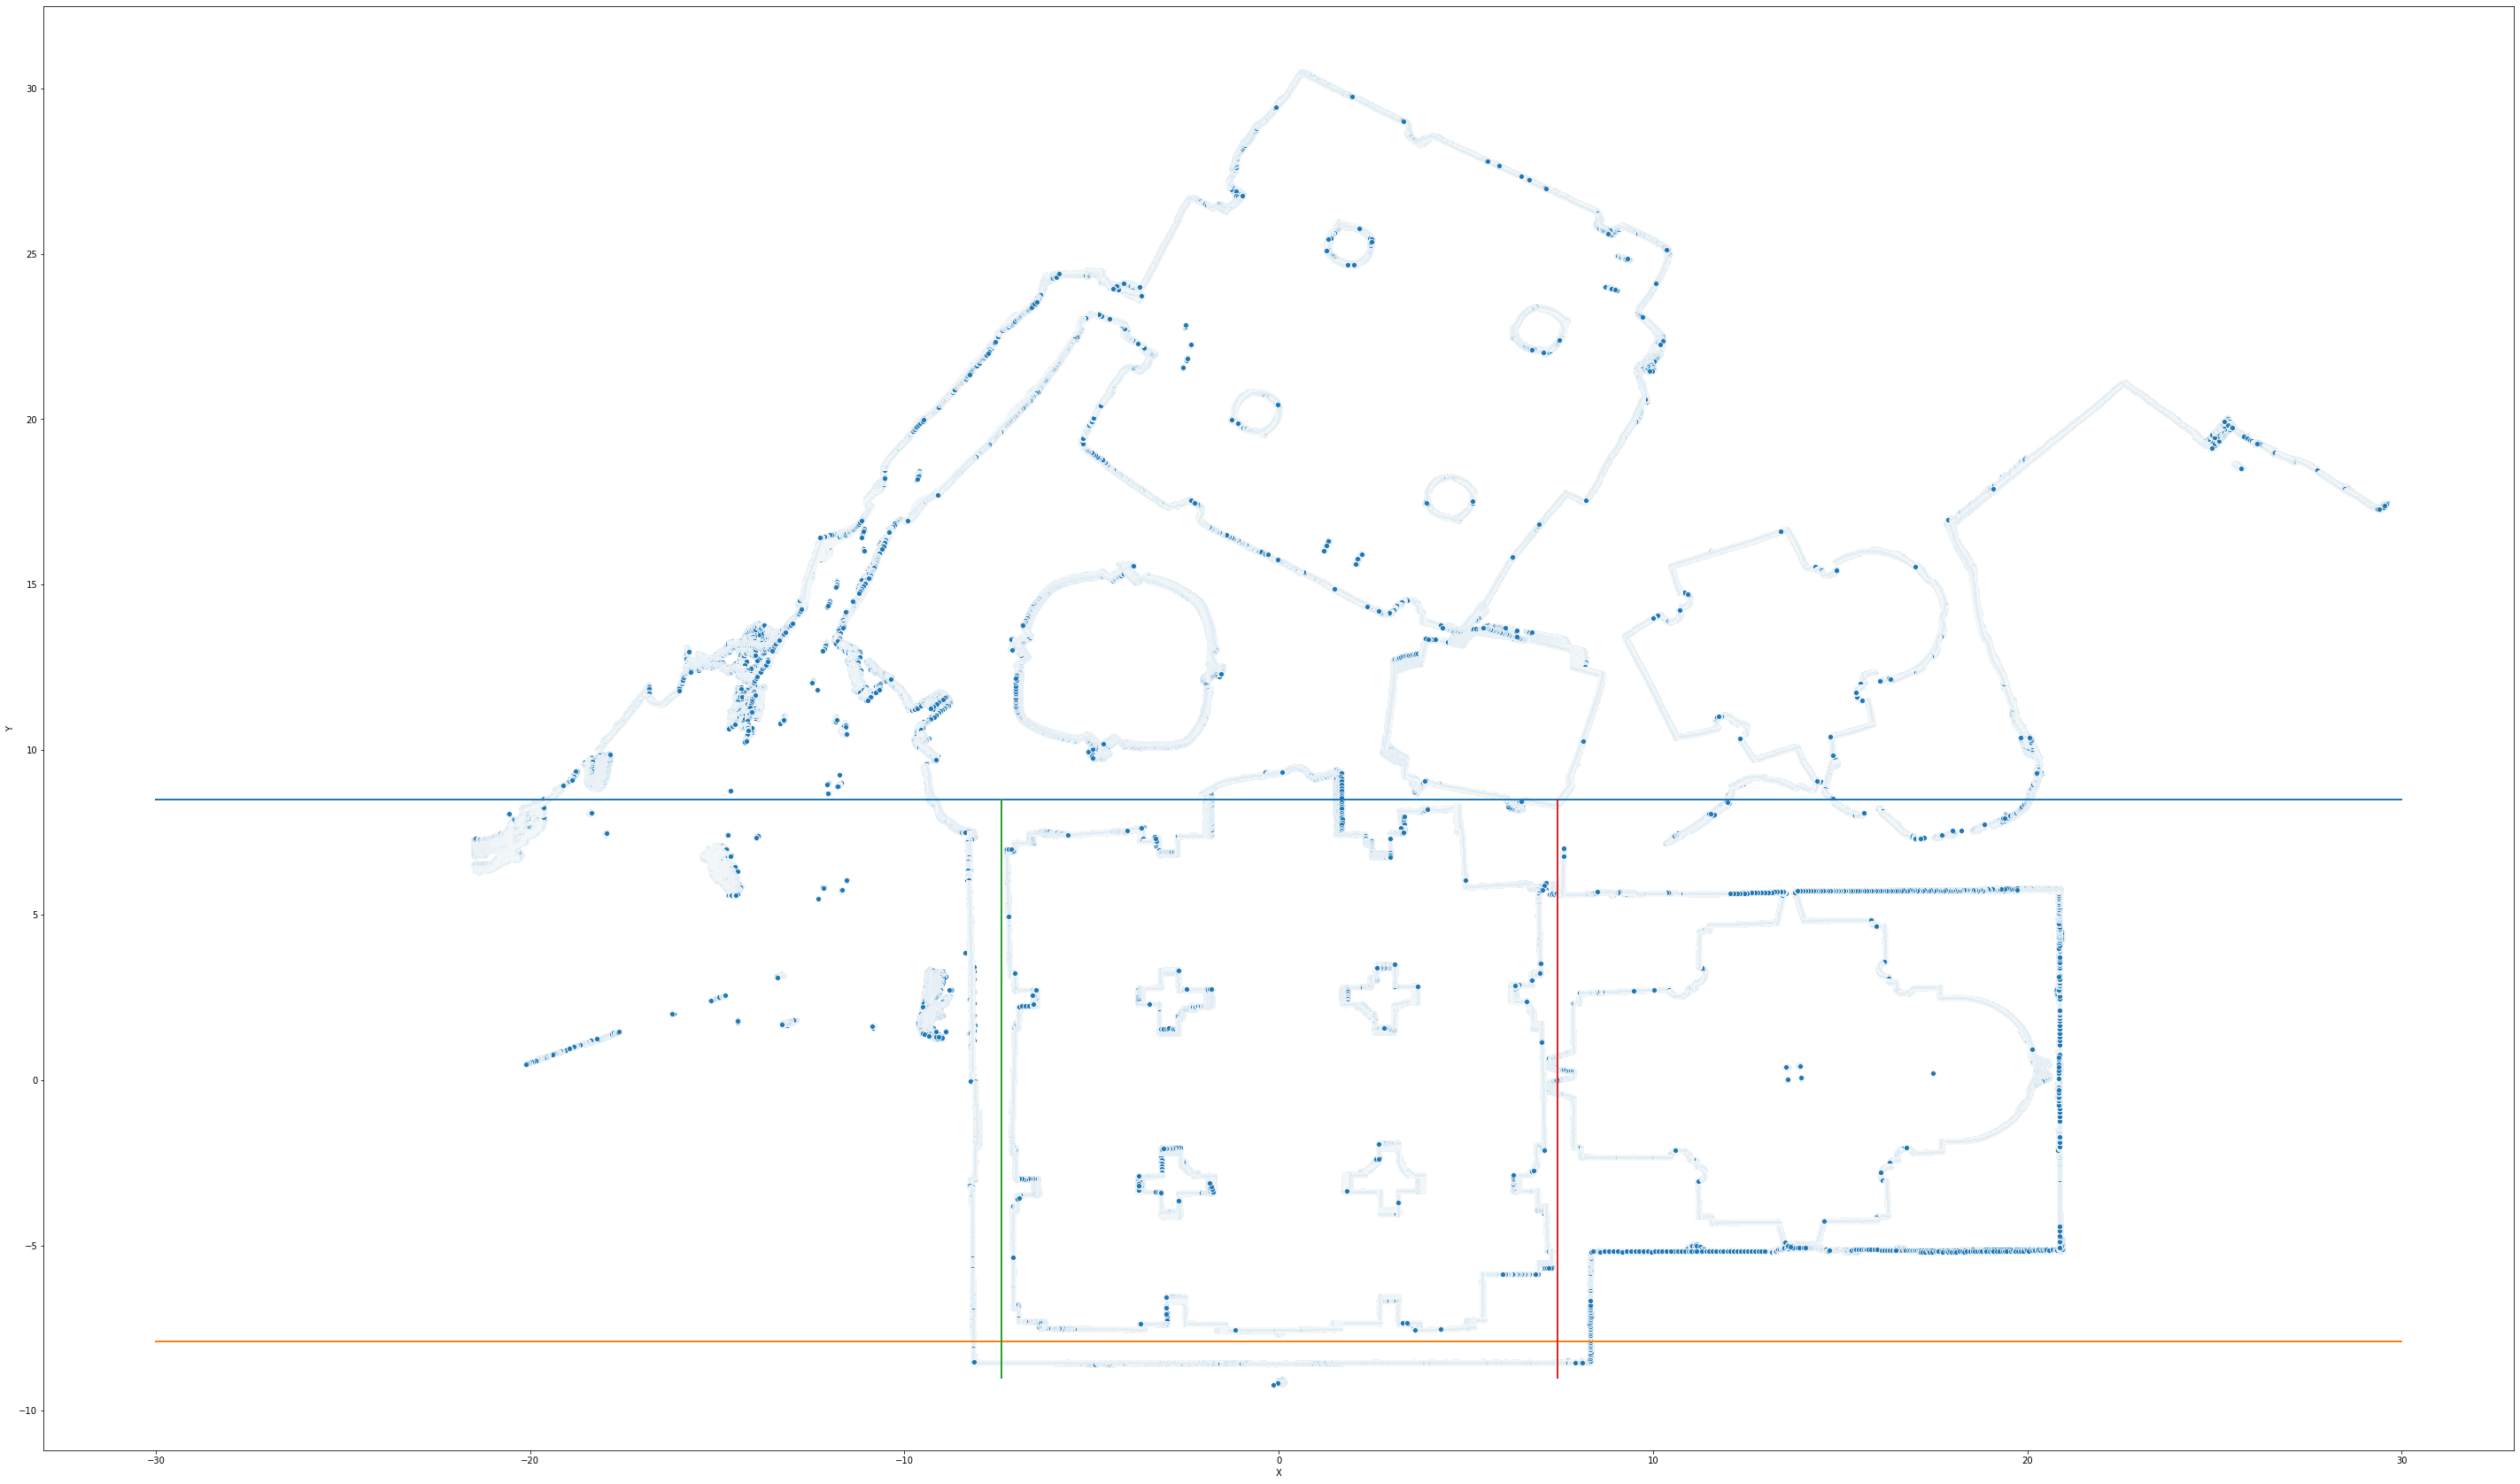

In [28]:
plt.figure(figsize = (50,30))
sns.scatterplot(x=(df[chunk].X), y = (df[chunk].Y))
plt.plot([-30,30],[8.5,8.5], linewidth=2) #Y crop line pos
plt.plot([-30,30],[-7.9,-7.9], linewidth=2) #Y crop line neg, ORANGE
plt.plot([-7.4,-7.4],[-9,8.5], linewidth=2) #X crop line neg, GREEN
plt.plot([7.45,7.45],[-9,8.5], linewidth=2) #X crop line pos, RED

In [7]:
crop_plan = ((df.X > x_neg) & (df.X < x_pos) & (df.Y > y_neg) & (df.Y < y_pos))

In [59]:
crp_df = df[crop_plan].copy()

In [63]:
crp_df.describe()

,X,Y,Z
count,4.253321e+07,4.253321e+07,4.253321e+07
mean,-1.498649e-01,5.720239e-01,2.598879e+00
std,4.616937e+00,4.991848e+00,3.025436e+00
min,-7.490000e+00,-7.890000e+00,-1.680000e+00
25%,-3.950000e+00,-3.410000e+00,-4.600000e-01
50%,-1.000000e-01,1.000000e+00,2.740000e+00
75%,3.760000e+00,4.880000e+00,5.340000e+00
max,7.440000e+00,8.490000e+00,1.291000e+01


**END LEGACY PROCESS**

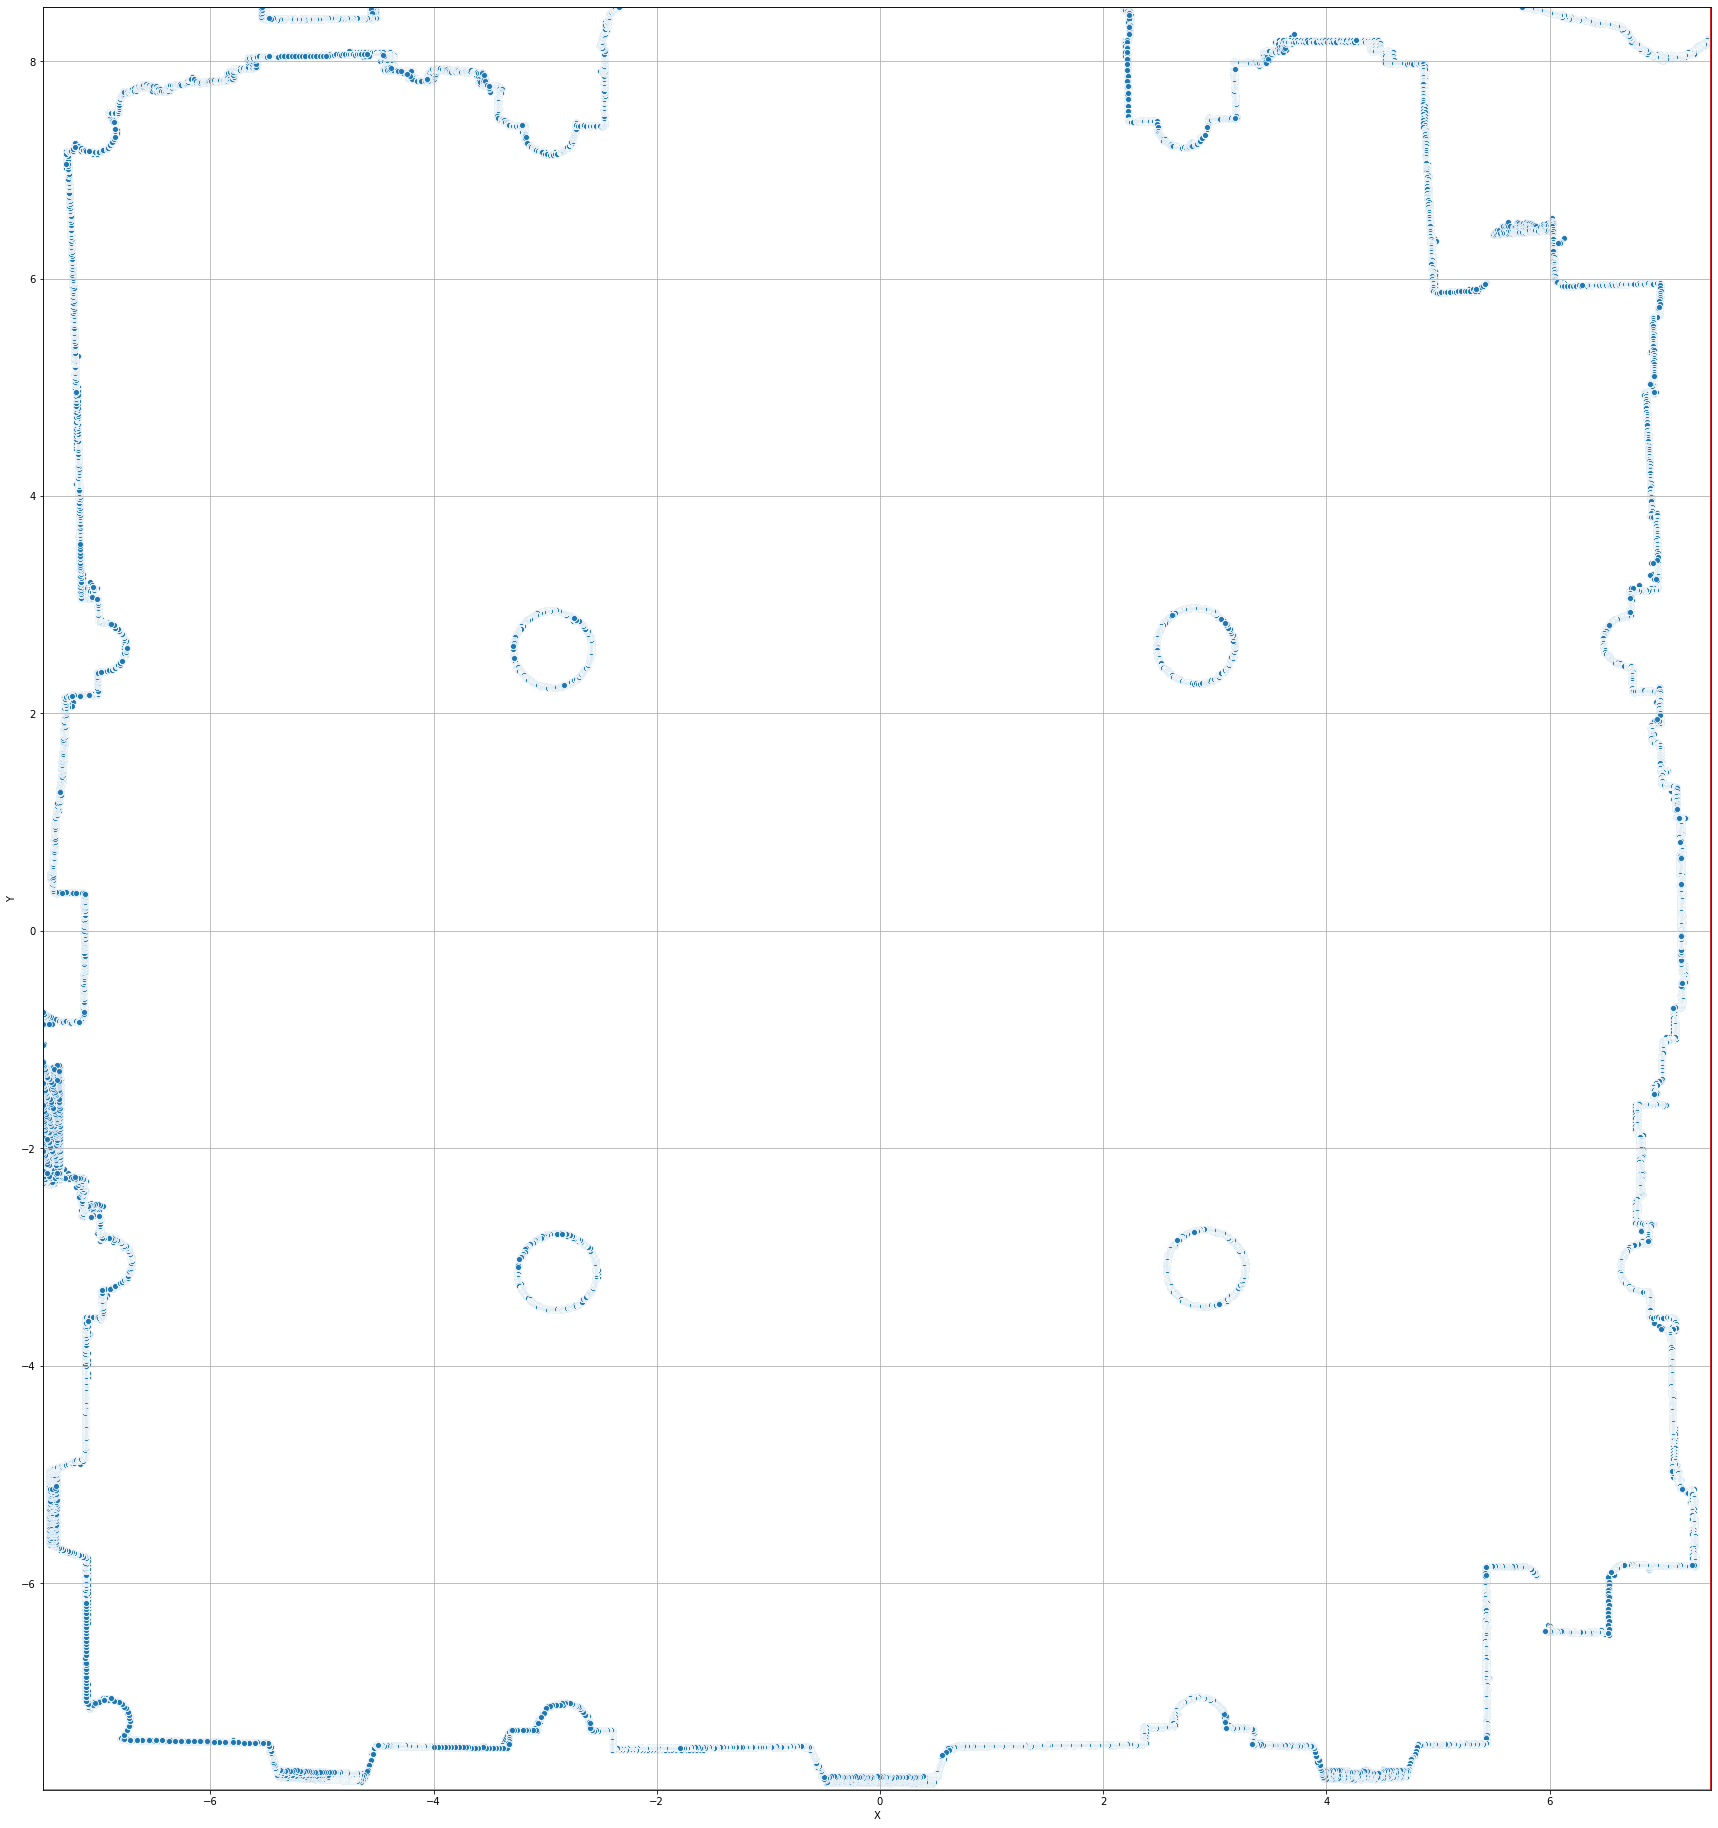

In [10]:
plt.figure(figsize = ((((x_neg*-1)+x_pos)*2),(((y_neg*-1)+y_pos)*2)))
plt.axis([x_neg, x_pos, y_neg, y_pos])
sns.scatterplot(x=(df[chunk].X), y = (df[chunk].Y))
plt.plot([x_neg,x_pos],[y_pos,y_pos], linewidth=2) #Y crop line pos
plt.plot([x_neg,x_pos],[y_neg,y_neg], linewidth=2) #Y crop line neg, ORANGE
plt.plot([x_neg,x_neg],[y_neg,y_pos], linewidth=2) #X crop line neg, GREEN
plt.plot([x_pos,x_pos],[y_neg,y_pos], linewidth=2) #X crop line pos, RED
plt.grid()

In [12]:
section = ((df.Y > .98) & (df.Y < 1))

In [17]:
crop_temp = (df.Z > -1.25)

In [18]:
df = df[crop_temp].copy()

<ipython-input-20-da9ea2c5d80c>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.scatterplot(x=(df[section].X), y = (df[section].Z))


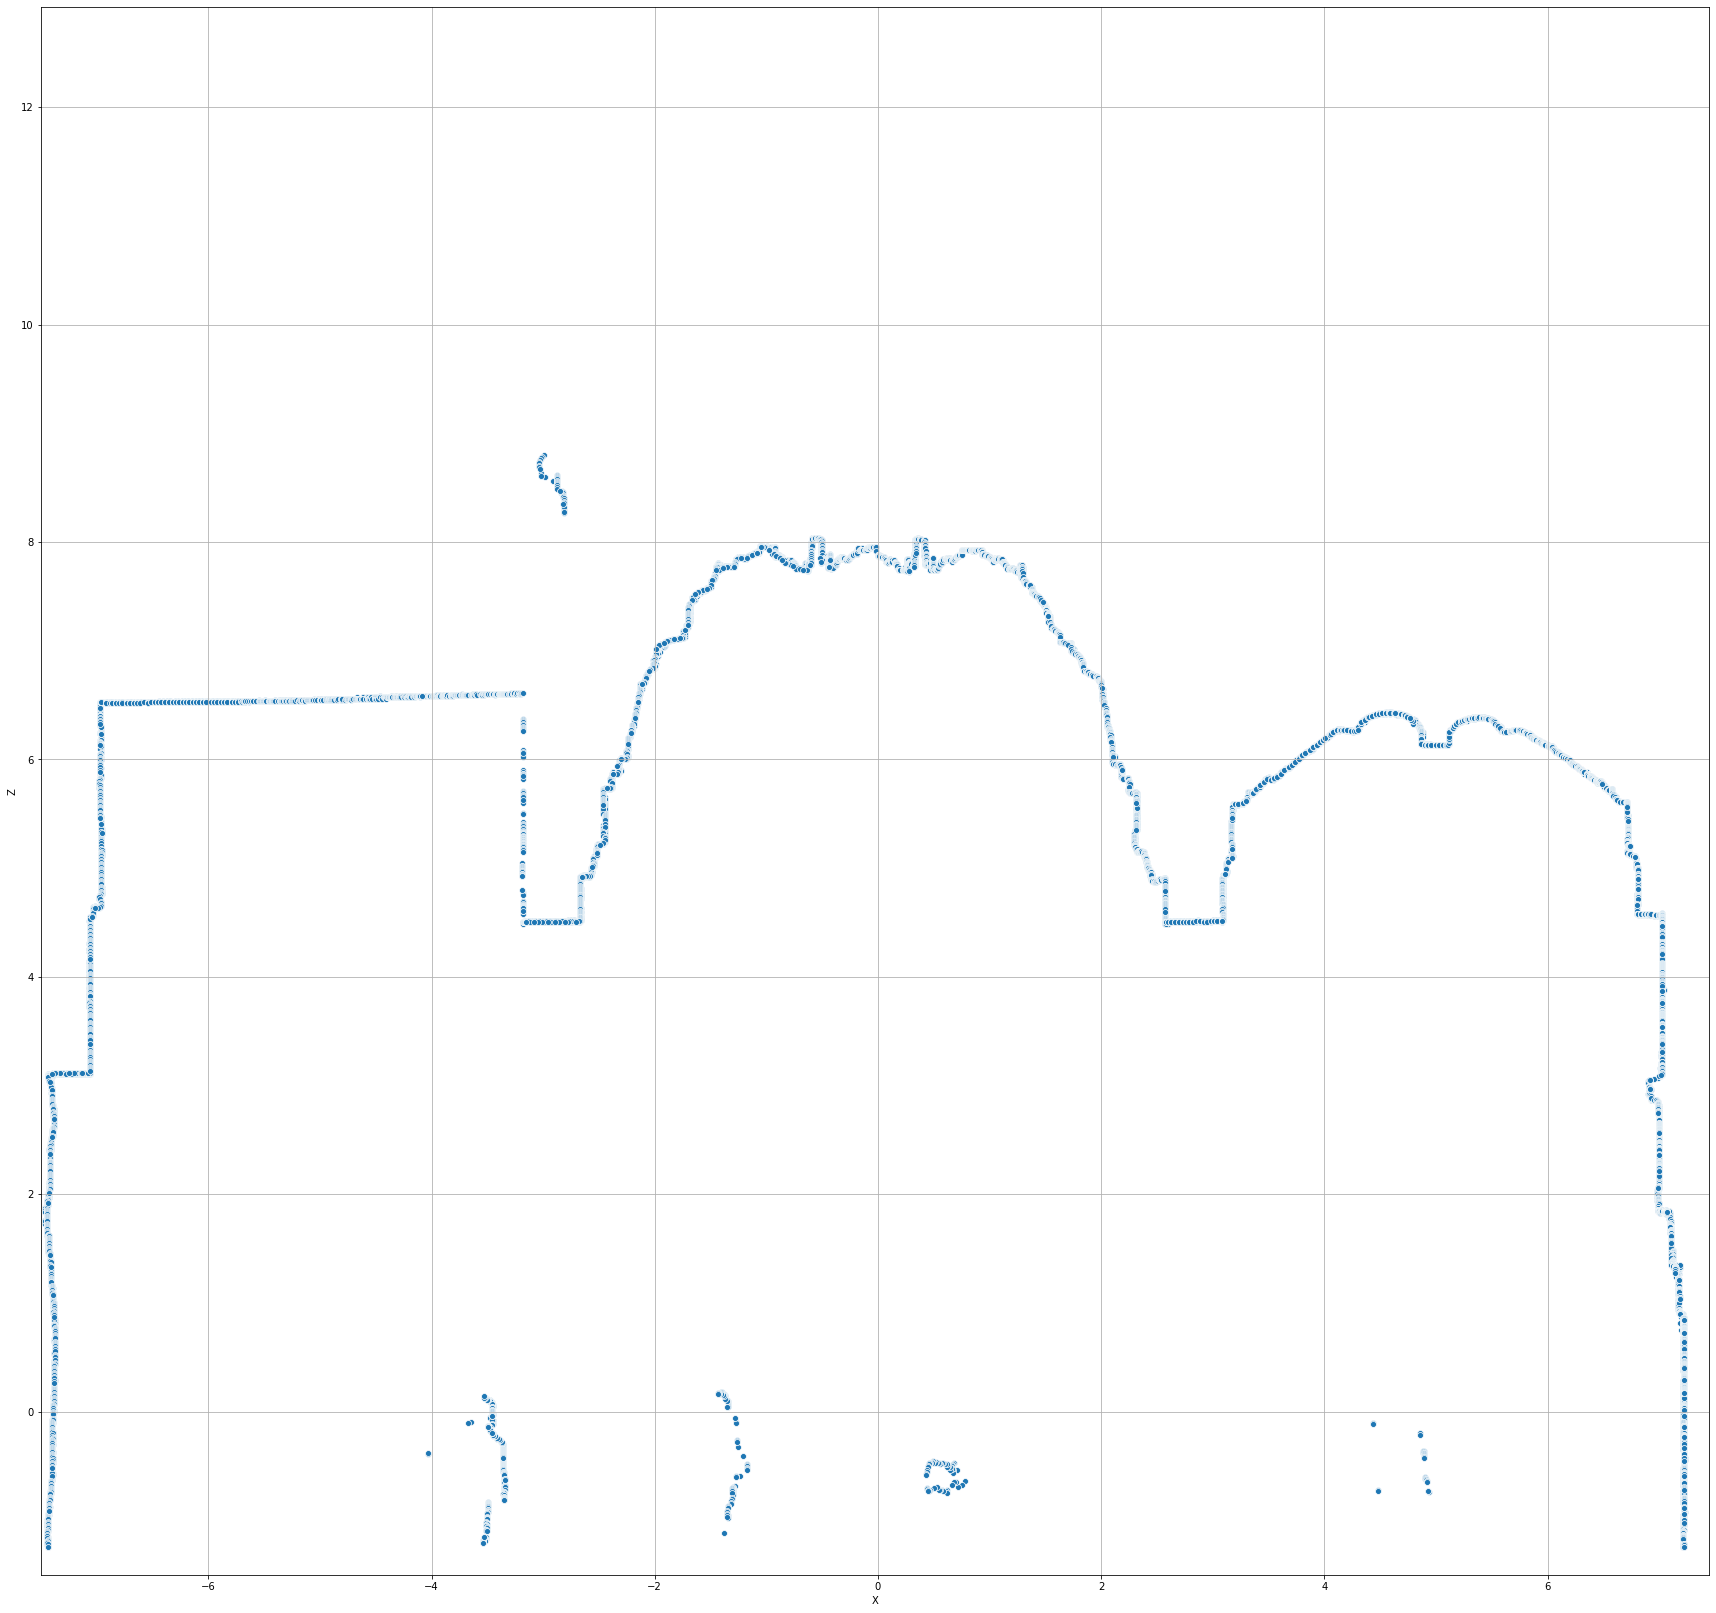

In [20]:
z_pos = 12.92
z_neg = -1.5
plt.figure(figsize = ((((x_neg*-1)+x_pos)*2),((z_neg*-1)+z_pos)*2))
plt.axis([x_neg, x_pos, z_neg, z_pos])
sns.scatterplot(x=(df[section].X), y = (df[section].Z))
plt.grid()

### THE VOXELIZER AND THE FOLLOWING PROCESSES ARE LEGACY METHODS NOT USED IN THE FINAL PROJECT

*This notebook is primarily used to describe the nature by which I was able to sort of understand the data. Example being, by voxelizing I was able to conceptualize the 'density' of the 

The voxelizer takes the x,y,z values of every row in the cropped dataframe, and 'rounds down' every value, and returns them in a tuple under a single column, 'voxel_key'. The goal here is to re-organize the data into voxels (cubes) that contain individual point clouds. Next, I'll preform calcs on the individual clouds to extract additional features. Down to ~860,000 rows. The X, Y, and Z columns are formatted into tuples containing 

In [87]:
def voxelizer(row):
    X_v = (np.floor((row.X*10)))/10
    Y_v = (np.floor((row.Y*10)))/10
    Z_v = (np.floor((row.Z*10)))/10
    return (X_v,Y_v,Z_v)

In [86]:
(np.floor((12.34*10)))/10

12.3

**V V V Self note: this took about 1.5 hrs to run V V V**

In [88]:
df['voxel_key'] = df.apply(voxelizer, axis = 1)

In [89]:
df.head(30)

,X,Y,Z,voxel_key
0,3.93,-6.60,6.10,"(3.9, -6.6, 6.1)"
1,3.91,-6.59,6.09,"(3.9, -6.6, 6.0)"
2,3.83,-6.57,6.06,"(3.8, -6.6, 6.0)"
3,3.82,-6.57,6.05,"(3.8, -6.6, 6.0)"
4,3.71,-6.53,5.98,"(3.7, -6.6, 5.9)"
5,3.68,-6.52,5.96,"(3.6, -6.6, 5.9)"
6,3.64,-6.51,5.92,"(3.6, -6.6, 5.9)"
7,3.59,-6.49,5.87,"(3.5, -6.5, 5.8)"
8,3.56,-6.48,5.84,"(3.5, -6.5, 5.8)"
9,3.56,-6.48,5.82,"(3.5, -6.5, 5.8)"


In [90]:
v_df = (df.groupby('voxel_key',as_index=False)
        .agg({'X':(lambda x: tuple(x)),
              'Y':(lambda y: tuple(y)),
              'Z':(lambda z: tuple(z))})
       )

Added a point count feature below. Checked on the distribution and we see a huge amount of nearly empty voxels, I am plotting the voxels on a x,y like the plan above in order to see if the nearly empty voxels are noise or part of the feature space...

In [91]:
v_df['pt_count'] = v_df.X.apply(lambda x: len(x))

In [92]:
v_df['glb_X'],v_df['glb_Y'],v_df['glb_Z'] = zip(*v_df.voxel_key)

In [93]:
v_df.describe()

,pt_count,glb_X,glb_Y,glb_Z
count,150010.000000,150010.000000,150010.000000,150010.000000
mean,696.744917,0.184294,0.133688,3.457874
std,600.052065,4.752227,4.994017,2.935445
min,1.000000,-7.500000,-7.900000,-1.300000
25%,134.000000,-3.600000,-3.800000,0.700000
50%,592.000000,0.400000,0.200000,3.900000
75%,1128.000000,4.500000,4.200000,5.800000
max,3596.000000,7.400000,8.500000,12.900000


In [177]:
v_df.to_csv('voxeltime.csv')

In [94]:
v_df.head()

,voxel_key,X,Y,Z,pt_count,glb_X,glb_Y,glb_Z
0,"(-7.5, -7.8, 7.2)","(-7.47, -7.48, -7.49, -7.5, -7.5)","(-7.72, -7.73, -7.75, -7.76, -7.78)","(7.29, 7.29, 7.29, 7.29, 7.29)",5,-7.5,-7.8,7.2
1,"(-7.5, -7.8, 7.3)","(-7.43, -7.43, -7.45, -7.45, -7.48)","(-7.71, -7.73, -7.73, -7.75, -7.75)","(7.3100000000000005, 7.3100000000000005, 7.310...",5,-7.5,-7.8,7.3
2,"(-7.5, -7.7, 7.2)","(-7.46, -7.46, -7.46, -7.46, -7.48)","(-7.62, -7.65, -7.68, -7.69, -7.7)","(7.29, 7.29, 7.29, 7.29, 7.29)",5,-7.5,-7.7,7.2
3,"(-7.5, -7.7, 7.3)","(-7.41, -7.41, -7.42, -7.42)","(-7.65, -7.67, -7.68, -7.7)","(7.3100000000000005, 7.3100000000000005, 7.310...",4,-7.5,-7.7,7.3
4,"(-7.5, -7.6, 7.2)","(-7.45, -7.5, -7.46)","(-7.5200000000000005, -7.57, -7.6000000000000005)","(7.29, 7.28, 7.28)",3,-7.5,-7.6,7.2


<AxesSubplot:xlabel='pt_count'>

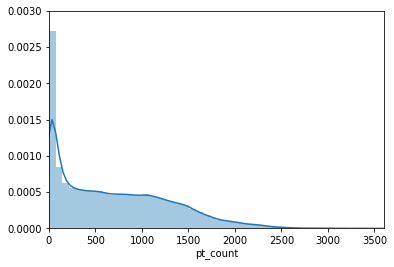

In [96]:
plt.axis([0,3600,0,.003])
sns.distplot(v_df['pt_count'])

In [97]:
(v_df.pt_count < 7).value_counts()

False    140456
True       9554
Name: pt_count, dtype: int64

In order to extract meaningful features from a voxel, it must contain a relative density of points. Right now, voxels containing less than 6 points are cut from the db. 3 points are required to describe a plane, so this layman's interpretation is that a minimum of 4 points are required to describe non-planarity, and probably 5 points in order for a relative amount of variance to be measured. 

What follows is an extraction of features from a point cloud that involves linear regression on each voxel. 

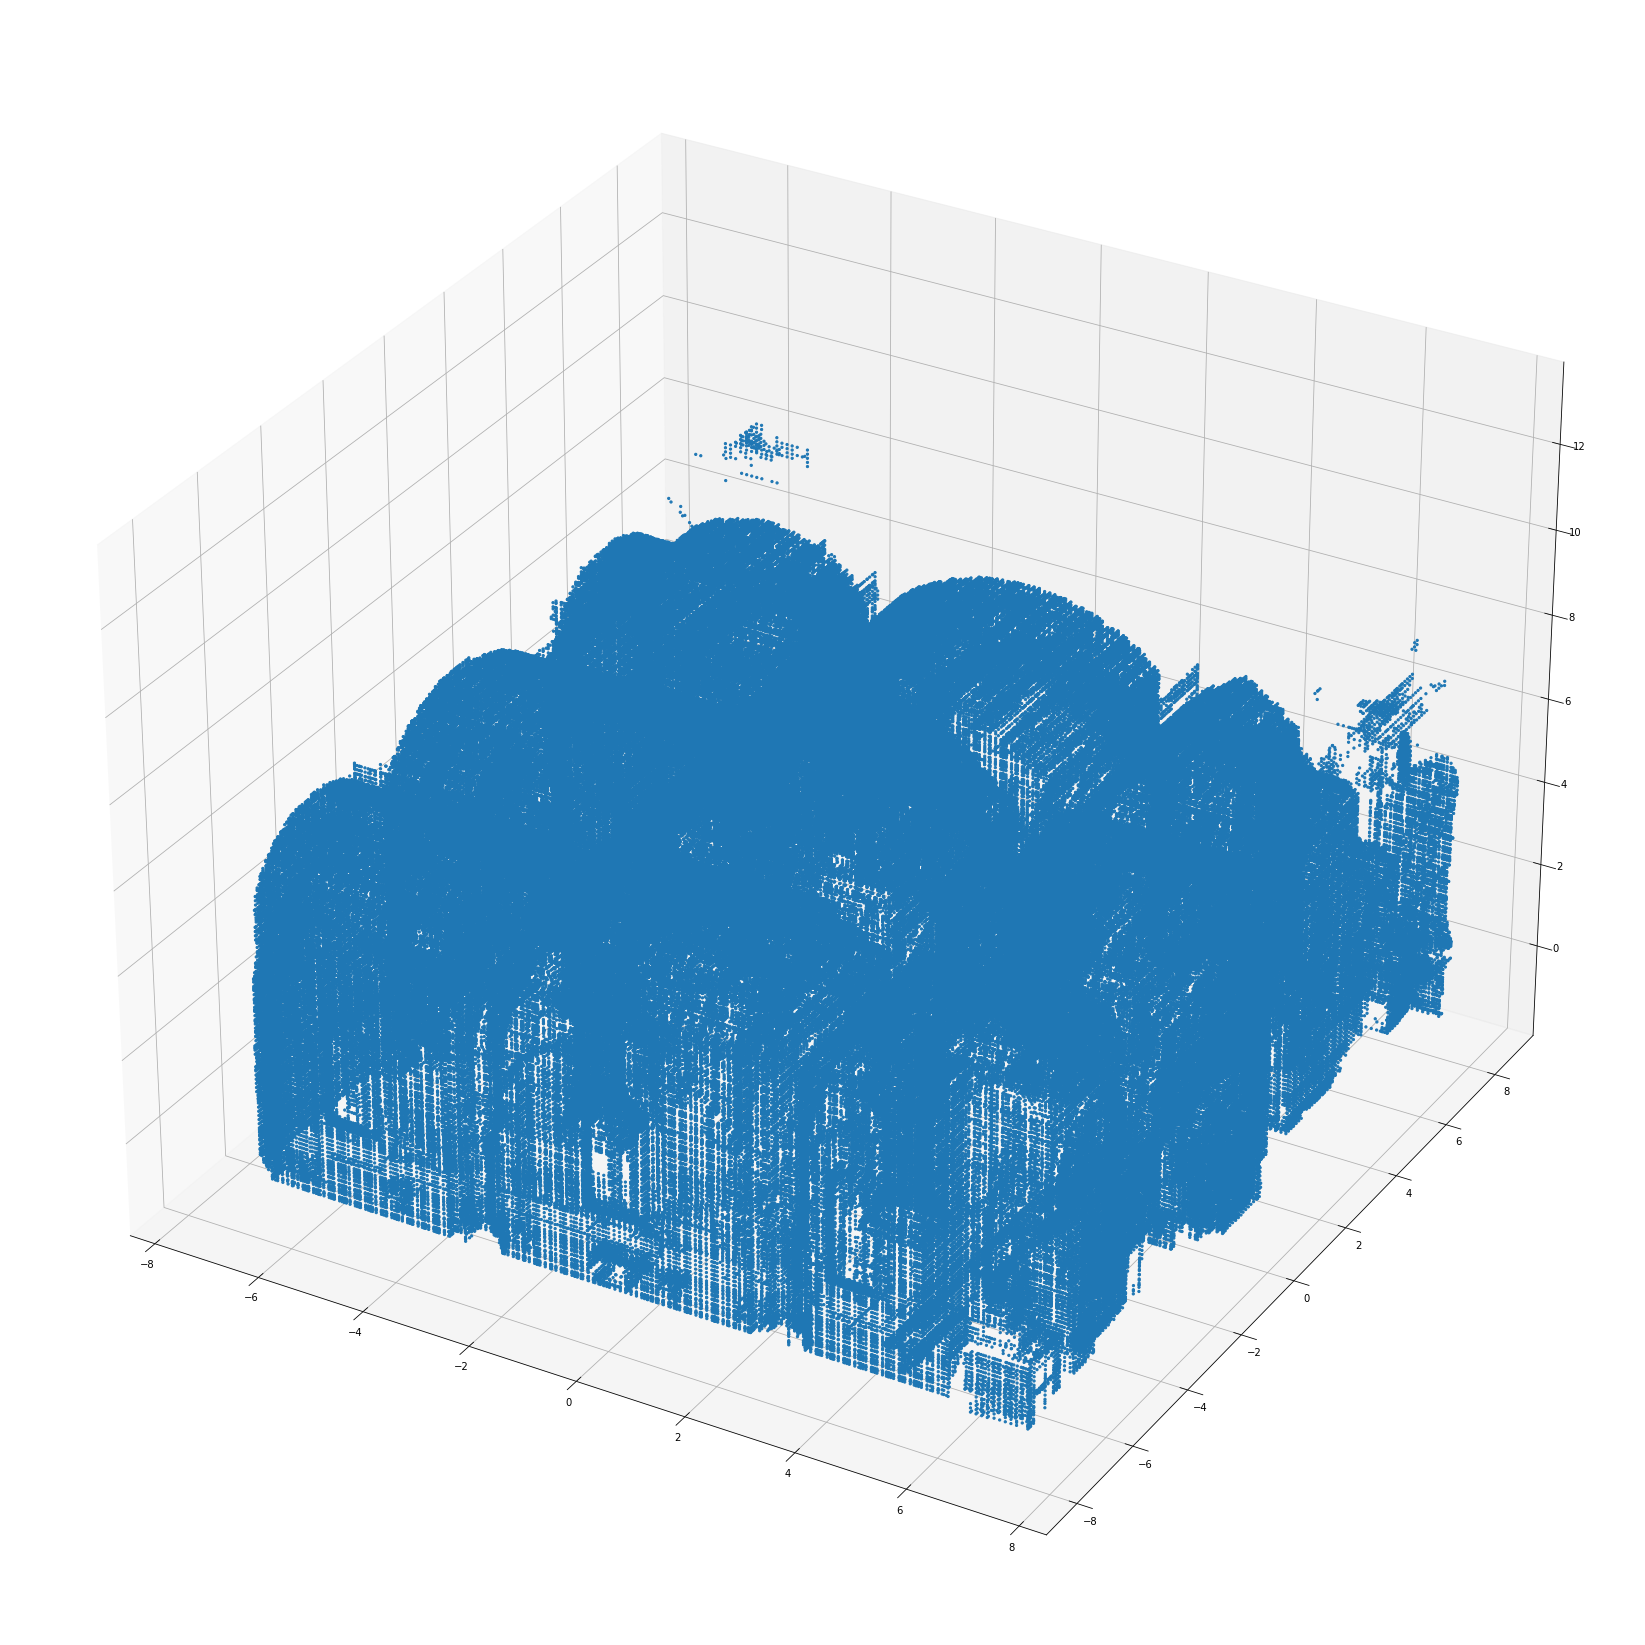

In [31]:
densevoxels = v_df.pt_count > 7
fig = plt.figure(figsize=(30,30))
ax = fig.add_subplot(projection='3d')

xs = v_df[densevoxels].glb_X
ys = v_df[densevoxels].glb_Y
zs = v_df[densevoxels].glb_Z
ax.scatter(xs, ys, zs, s=5, alpha = 1)

plt.show()

In [98]:
chonk = (v_df.glb_Y == 1.70) & (v_df.pt_count > 7)

In [100]:
(v_df.glb_Y == 1.7).value_counts()

False    149064
True        946
Name: glb_Y, dtype: int64

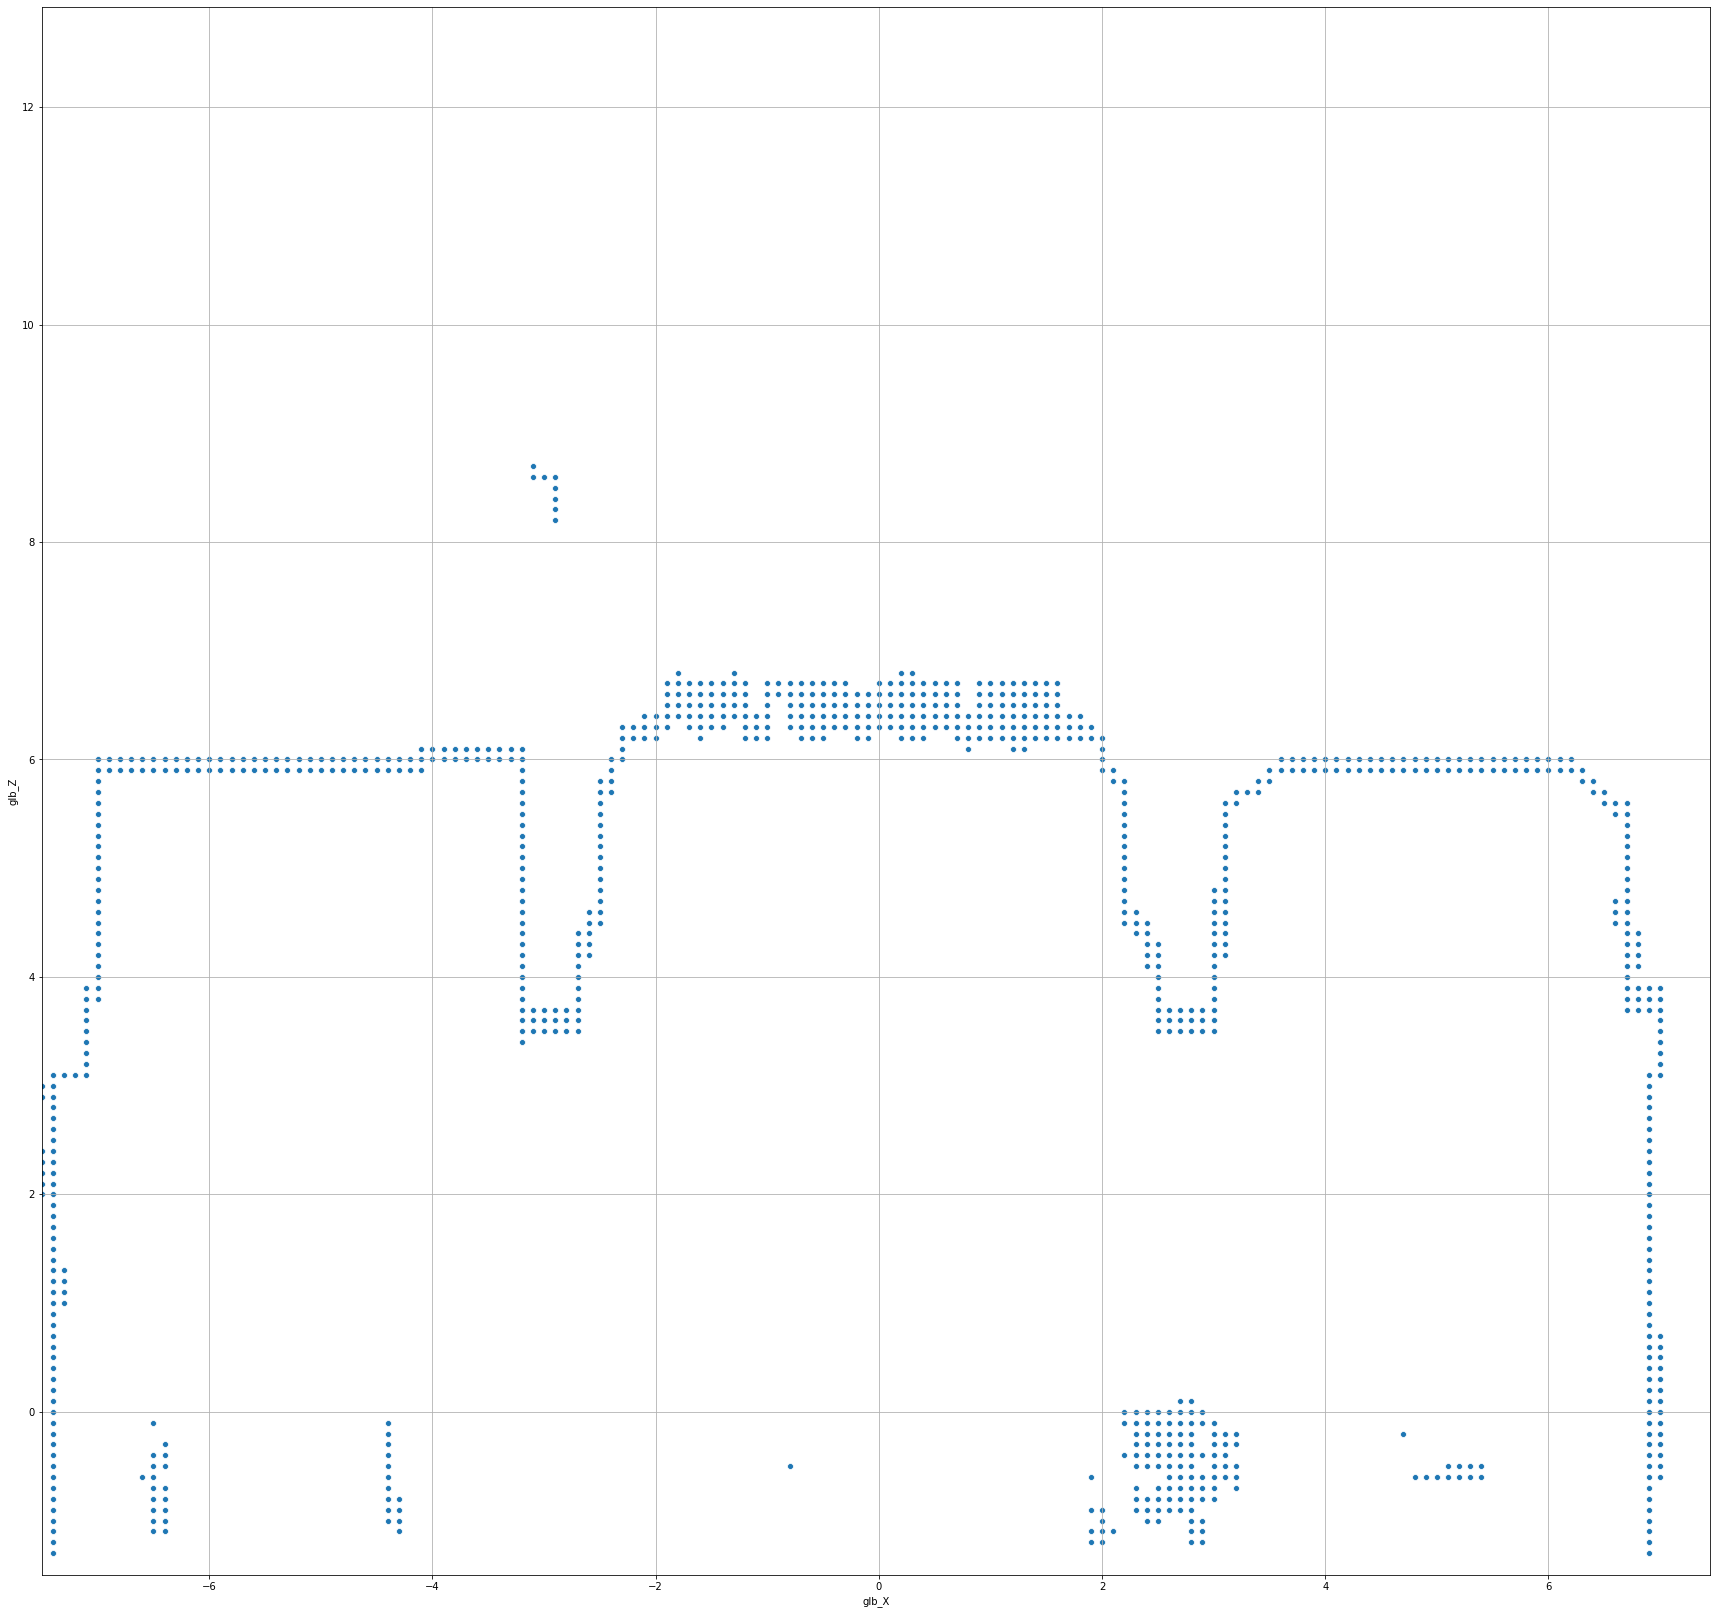

In [99]:
plt.figure(figsize = ((((x_neg*-1)+x_pos)*2),((z_neg*-1)+z_pos)*2))
plt.axis([x_neg, x_pos, z_neg, z_pos])
sns.scatterplot(x=(v_df[chonk].glb_X), y = (v_df[chonk].glb_Z))
plt.grid()

In [174]:
from sklearn.linear_model import LinearRegression

def regressor_y(row):
    x = np.asarray(row['X']).reshape(-1,1)
    y = np.asarray(row['Z']).reshape(-1,1)
    reg = LinearRegression().fit(x,y)
    score = reg.score(x,y)
    slope = float(reg.coef_)
    return slope, score
    

In [162]:
mini_df = v_df.head(10).copy()

In [121]:
x = np.asarray(mini_df.X[1]).reshape(-1,1)
y = np.asarray(mini_df.Z[1]).reshape(-1,1)
reg = LinearRegression().fit(x,y)
slope = reg.coef_

In [176]:
mini_df.head(10)

,voxel_key,X,Y,Z,pt_count,glb_X,glb_Y,glb_Z,Y_slope
0,"(-7.5, -7.8, 7.2)","(-7.47, -7.48, -7.49, -7.5, -7.5)","(-7.72, -7.73, -7.75, -7.76, -7.78)","(7.29, 7.29, 7.29, 7.29, 7.29)",5,-7.5,-7.8,7.2,"(3.475133569059918e-27, 0.0)"
1,"(-7.5, -7.8, 7.3)","(-7.43, -7.43, -7.45, -7.45, -7.48)","(-7.71, -7.73, -7.73, -7.75, -7.75)","(7.3100000000000005, 7.3100000000000005, 7.310...",5,-7.5,-7.8,7.3,"(-0.0, 1.0)"
2,"(-7.5, -7.7, 7.2)","(-7.46, -7.46, -7.46, -7.46, -7.48)","(-7.62, -7.65, -7.68, -7.69, -7.7)","(7.29, 7.29, 7.29, 7.29, 7.29)",5,-7.5,-7.7,7.2,"(-4.9500751711306626e-27, 0.0)"
3,"(-7.5, -7.7, 7.3)","(-7.41, -7.41, -7.42, -7.42)","(-7.65, -7.67, -7.68, -7.7)","(7.3100000000000005, 7.3100000000000005, 7.310...",4,-7.5,-7.7,7.3,"(-0.0, 1.0)"
4,"(-7.5, -7.6, 7.2)","(-7.45, -7.5, -7.46)","(-7.5200000000000005, -7.57, -7.6000000000000005)","(7.29, 7.28, 7.28)",3,-7.5,-7.6,7.2,"(0.14285714285713957, 0.42857142857137787)"
5,"(-7.5, -5.7, 1.0)","(-7.41, -7.41, -7.44, -7.42, -7.41, -7.43, -7....","(-5.66, -5.66, -5.65, -5.64, -5.65, -5.63, -5....","(1.08, 1.07, 1.09, 1.07, 1.05, 1.07, 1.05, 1.0...",575,-7.5,-5.7,1.0,"(-0.8926818483307515, 0.5127351477934903)"
6,"(-7.5, -5.7, 1.1)","(-7.44, -7.44, -7.44, -7.44, -7.43, -7.42, -7....","(-5.66, -5.66, -5.66, -5.66, -5.66, -5.65, -5....","(1.19, 1.17, 1.16, 1.1400000000000001, 1.13000...",1502,-7.5,-5.7,1.1,"(-0.189588664040151, 0.03346741842074241)"
7,"(-7.5, -5.7, 1.2)","(-7.45, -7.45, -7.45, -7.45, -7.45, -7.45, -7....","(-5.65, -5.65, -5.65, -5.66, -5.66, -5.66, -5....","(1.29, 1.28, 1.26, 1.25, 1.23, 1.22, 1.2, 1.28...",1342,-7.5,-5.7,1.2,"(-0.006209847949811686, 3.6957158571881976e-05)"
8,"(-7.5, -5.7, 1.3)","(-7.41, -7.41, -7.41, -7.41, -7.47, -7.47, -7....","(-5.67, -5.67, -5.67, -5.67, -5.65, -5.65, -5....","(1.3900000000000001, 1.37, 1.36, 1.34, 1.39000...",1373,-7.5,-5.7,1.3,"(-0.0017002468021572706, 2.680988882342028e-06)"
9,"(-7.5, -5.7, 1.4)","(-7.41, -7.41, -7.46, -7.46, -7.47, -7.46, -7....","(-5.66, -5.66, -5.64, -5.65, -5.64, -5.64, -5....","(1.49, 1.47, 1.42, 1.41, 1.48, 1.47, 1.44, 1.4...",1280,-7.5,-5.7,1.4,"(-0.016236264534772837, 0.000247287678874053)"


In [175]:
mini_df['Y_slope'] = mini_df.apply(regressor_y, axis=1)

<ipython-input-244-63daefcef8fd>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sb.scatterplot(x=(crp_df[chonk].X), y = (crp_df[chonk].Z))


<AxesSubplot:xlabel='X', ylabel='Z'>

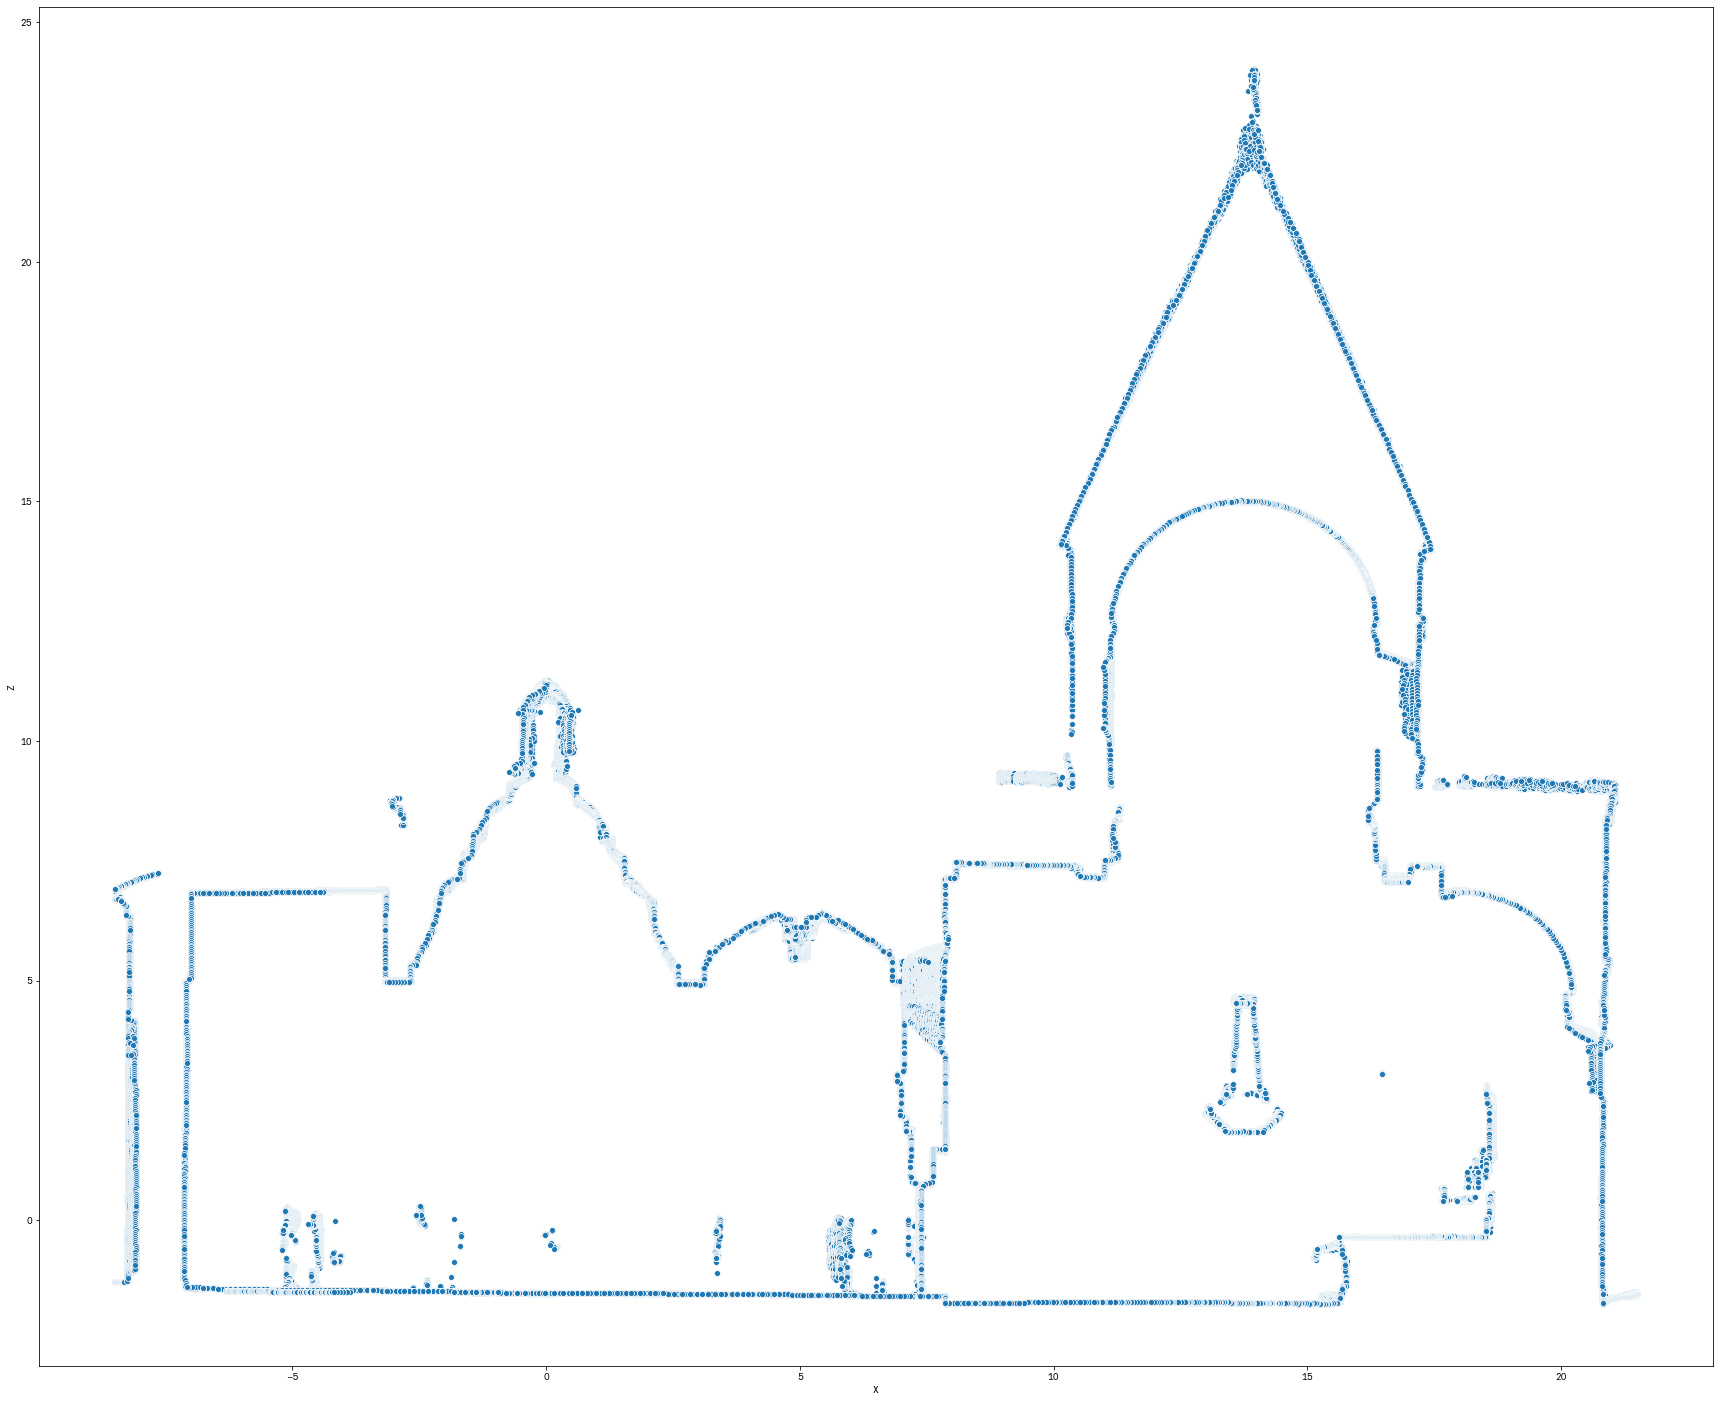

In [244]:

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Executive'

plt.figure(figsize = (30,25))
sb.scatterplot(x=(crp_df[chonk].X), y = (crp_df[chonk].Z))
#plt.plot([-6.3,-6.3],[-9,8.5], linewidth=2) 
#plt.plot([-4,-4],[-9,8.5], linewidth=2) 

In [239]:
chonk = ((df.Y > (-0.1)) & (df.Y < .1))

In [240]:
chonk.value_counts()

False    175798317
True        937525
Name: Y, dtype: int64

In [226]:
crp_df['cross'] = crp_df.X.apply(lambda x: float(str(x)[:-1]))

In [237]:
crp_df.describe()

,X,Y,Z
count,8.318561e+07,8.318561e+07,8.318561e+07
mean,5.737361e+00,-3.778252e-01,2.858509e+00
std,8.646598e+00,4.901810e+00,3.549555e+00
min,-8.490000e+00,-8.990000e+00,-1.930000e+00
25%,-1.800000e+00,-4.630000e+00,-2.100000e-01
50%,5.290000e+00,-4.500000e-01,2.540000e+00
75%,1.329000e+01,3.500000e+00,5.380000e+00
max,2.149000e+01,8.490000e+00,2.431000e+01


In [192]:
x = 1.17
round(x,1)

1.2

In [219]:
x = 31.19
float(str(x)[:-1])

31.1

In [236]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25493760 entries, 82 to 176403530
Data columns (total 4 columns):
 #   Column    Dtype  
---  ------    -----  
 0   X         float64
 1   Y         float64
 2   Z         float64
 3   pred_hrd  object 
dtypes: float64(3), object(1)
memory usage: 1.6+ GB
